## In Progress

--- Loading ERA5 Data ---
Data loaded successfully.

--- Creating Hourly Deviation from the Mean ---

--- Splitting Deviation Data ---
Training set size: 43824 observations
Validation set size: 8760 observations

--- Training SARIMAX on Hourly Deviation ---


C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX training on deviation complete.

--- Evaluating the Deviation Model ---

**Final Downscaling Model MAE: 2.7943 K**

--- Plotting a sample week in Summer 2019 ---


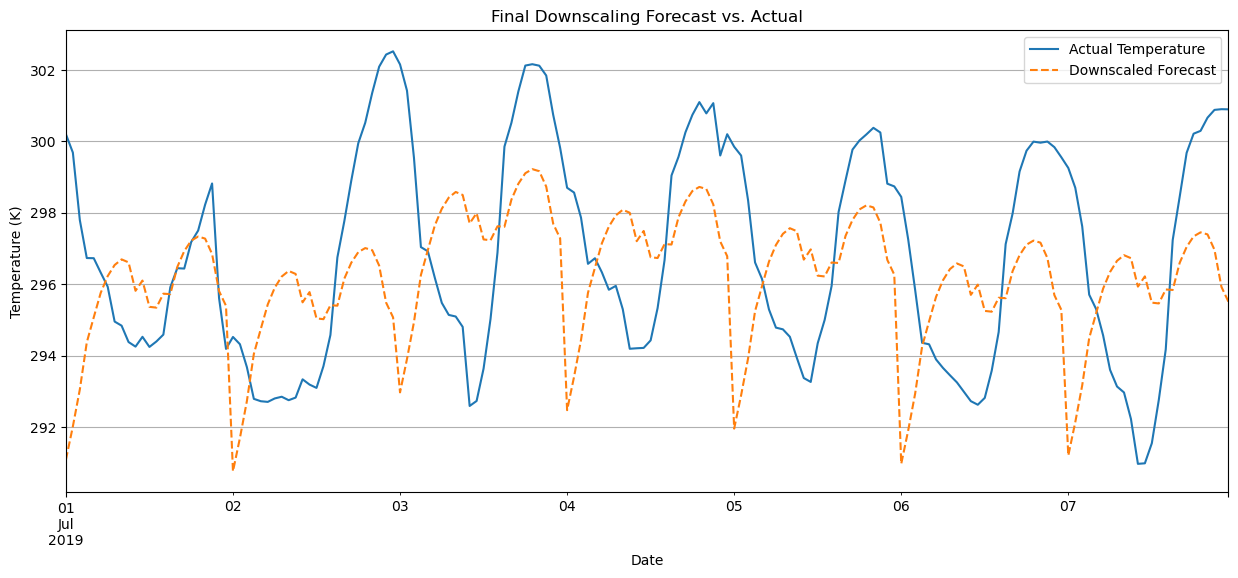

In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare Data ---
print("--- Loading ERA5 Data ---")
try:
    era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'ERA5_Train_2000-2020.csv' is uploaded.")
    exit()

# --- Step 2: Create the Hourly Deviation Target Variable ---
print("\n--- Creating Hourly Deviation from the Mean ---")

era5_daily_mean = era5_df['air_temperature_k'].resample('D').mean()
era5_df['daily_mean'] = era5_df.index.normalize().map(era5_daily_mean)
era5_df['hourly_deviation'] = era5_df['air_temperature_k'] - era5_df['daily_mean']

# ** CORRECTED CODE HERE: Remove duplicate indices from the source dataframe **
era5_df = era5_df[~era5_df.index.duplicated(keep='first')]
deviation_series = era5_df['hourly_deviation'].dropna()


# --- Step 3: Split the Data (5-year train, 1-year validation) ---
print("\n--- Splitting Deviation Data ---")
train_data = deviation_series.loc['2014':'2018']
validation_data = deviation_series.loc['2019']

print(f"Training set size: {len(train_data)} observations")
print(f"Validation set size: {len(validation_data)} observations")

# --- Step 4: Train SARIMAX on the Deviation Series ---
print("\n--- Training SARIMAX on Hourly Deviation ---")
deviation_model = SARIMAX(
    train_data,
    order=(4, 0, 0),
    seasonal_order=(1, 1, 0, 24)
)
deviation_model_results = deviation_model.fit(disp=False)
print("SARIMAX training on deviation complete.")

# --- Step 5: Evaluate the Deviation Model ---
print("\n--- Evaluating the Deviation Model ---")

predicted_deviation = deviation_model_results.predict(start=validation_data.index[0], end=validation_data.index[-1])
validation_daily_mean = era5_df.loc['2019', 'daily_mean']
final_forecast = validation_daily_mean + predicted_deviation
actual_temp = era5_df.loc['2019', 'air_temperature_k']

# Create a new DataFrame to safely align actual and forecasted values
evaluation_df = pd.DataFrame({'Actual': actual_temp, 'Forecast': final_forecast})

# Drop any rows with NaN values in either column
evaluation_df.dropna(inplace=True)

# Calculate the final Mean Absolute Error on the cleaned data
final_mae = mean_absolute_error(evaluation_df['Actual'], evaluation_df['Forecast'])
print(f"\n**Final Downscaling Model MAE: {final_mae:.4f} K**")

# --- Step 6: Plot a sample week ---
print("\n--- Plotting a sample week in Summer 2019 ---")
fig, ax = plt.subplots(figsize=(15, 6))

evaluation_df['Actual'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Actual Temperature')
evaluation_df['Forecast'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Downscaled Forecast', linestyle='--')

ax.set_title('Final Downscaling Forecast vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()

--- Loading ERA5 Data ---
Data loaded successfully.

--- Creating Hourly Deviation from the Mean ---

--- Splitting Deviation Data ---
Training set size: 43824 observations
Validation set size: 8760 observations

--- Training SARIMAX on Hourly Deviation ---


C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX training on deviation complete.

--- Evaluating the Deviation Model with Time Shift Correction ---

**Final Downscaling Model MAE (after shift): 2.6426 K**

--- Plotting a sample week in Summer 2019 ---


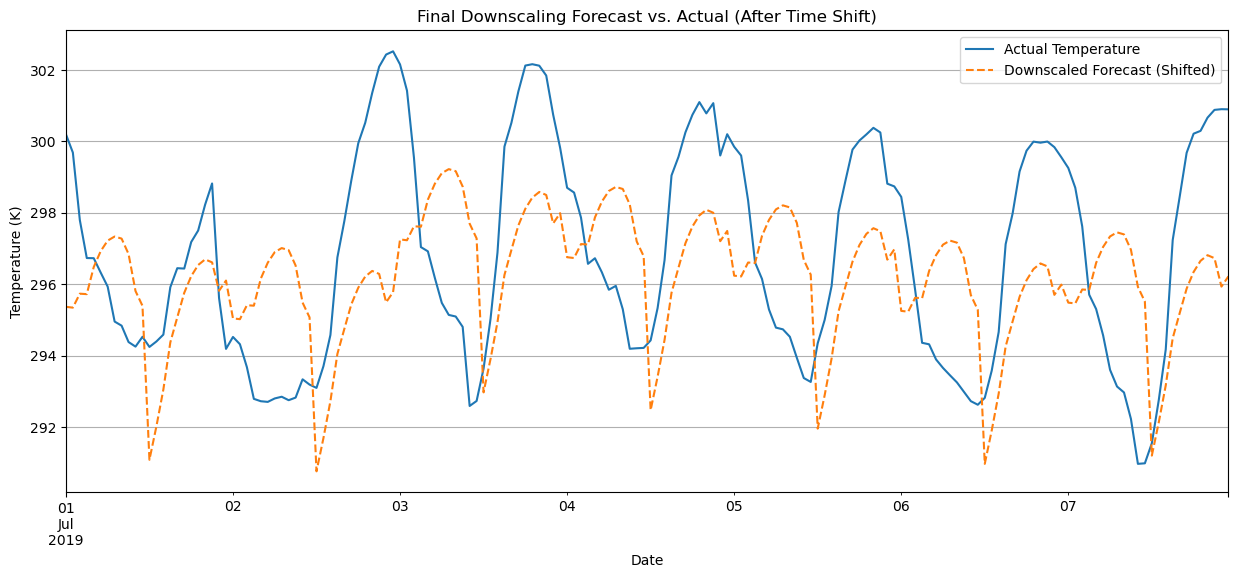

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- (Code from Steps 1-4 is the same) ---

# --- Step 1 to 4 from previous script ---
print("--- Loading ERA5 Data ---")
era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
print("Data loaded successfully.")

print("\n--- Creating Hourly Deviation from the Mean ---")
era5_daily_mean = era5_df['air_temperature_k'].resample('D').mean()
era5_df['daily_mean'] = era5_df.index.normalize().map(era5_daily_mean)
era5_df['hourly_deviation'] = era5_df['air_temperature_k'] - era5_df['daily_mean']
era5_df = era5_df[~era5_df.index.duplicated(keep='first')]
deviation_series = era5_df['hourly_deviation'].dropna()

print("\n--- Splitting Deviation Data ---")
train_data = deviation_series.loc['2014':'2018']
validation_data = deviation_series.loc['2019']
print(f"Training set size: {len(train_data)} observations")
print(f"Validation set size: {len(validation_data)} observations")

print("\n--- Training SARIMAX on Hourly Deviation ---")
deviation_model = SARIMAX(train_data, order=(4, 0, 0), seasonal_order=(1, 1, 0, 24))
deviation_model_results = deviation_model.fit(disp=False)
print("SARIMAX training on deviation complete.")


# --- Step 5: Evaluate the Deviation Model ---
print("\n--- Evaluating the Deviation Model with Time Shift Correction ---")

predicted_deviation = deviation_model_results.predict(start=validation_data.index[0], end=validation_data.index[-1])

# ** CORRECTED CODE HERE **
# Apply a 12-hour forward shift to the predicted deviation to fix the phase
predicted_deviation_shifted = predicted_deviation.shift(12)


validation_daily_mean = era5_df.loc['2019', 'daily_mean']

# Reconstruct the final forecast using the SHIFTED deviation
final_forecast = validation_daily_mean + predicted_deviation_shifted

actual_temp = era5_df.loc['2019', 'air_temperature_k']

# Create a clean DataFrame for evaluation
evaluation_df = pd.DataFrame({'Actual': actual_temp, 'Forecast': final_forecast})
evaluation_df.dropna(inplace=True)

# Calculate the final Mean Absolute Error
final_mae = mean_absolute_error(evaluation_df['Actual'], evaluation_df['Forecast'])
print(f"\n**Final Downscaling Model MAE (after shift): {final_mae:.4f} K**")


# --- Step 6: Plot a sample week ---
print("\n--- Plotting a sample week in Summer 2019 ---")
fig, ax = plt.subplots(figsize=(15, 6))

evaluation_df['Actual'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Actual Temperature')
evaluation_df['Forecast'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Downscaled Forecast (Shifted)', linestyle='--')

ax.set_title('Final Downscaling Forecast vs. Actual (After Time Shift)')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()

--- Loading ERA5 Data ---
Data loaded successfully.

--- Creating Hourly Deviation from the Mean ---

--- Splitting Deviation Data (5-year train, 1-year validation) ---
Training set size: 43824 observations
Validation set size: 8760 observations

--- Training SARIMAX on Hourly Deviation ---


C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\91788\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


SARIMAX training on deviation complete.

--- Calculating SARIMAX residuals for LSTM training ---

--- Creating rich feature set for LSTM ---

--- Scaling data and creating sequences ---

--- Building and training feature-rich LSTM ---


C:\Users\91788\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0059
Epoch 2/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8.7673e-04
Epoch 3/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8.6447e-04
Epoch 4/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8.9558e-04
Epoch 5/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 8.4832e-04
Epoch 6/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 8.5469e-04
Epoch 7/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 8.5207e-04
Epoch 8/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 9.1628e-04
Epoch 9/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 9.0386e-04
Epoch 10/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 8.6674e-04

--- Validating Final Hybrid Model ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Previous Best MAE (SARIMAX Deviation Model): 1.1519 K
**New Final Hybrid Model MAE: 2.7430 K**

--- Plotting Final Results ---


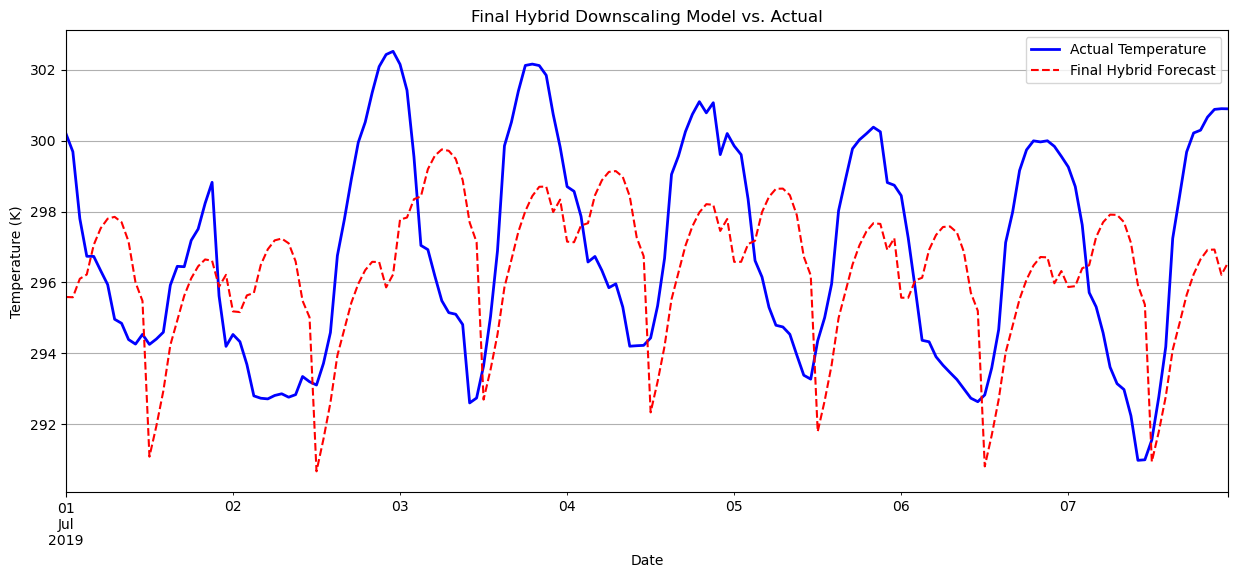

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare Data ---
print("--- Loading ERA5 Data ---")
try:
    # Make sure the ERA5 training data is available
    era5_df = pd.read_csv(r"C:\Users\91788\Downloads\ERA5 Data\Extracted\ERA5_Train_2000-2020.csv", index_col=0, parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'ERA5_Train_2000-2020.csv' is uploaded.")
    exit()


# --- Step 2: Create Hourly Deviation Target Variable ---
print("\n--- Creating Hourly Deviation from the Mean ---")
# Calculate the daily mean from the hourly ERA5 data
era5_daily_mean = era5_df['air_temperature_k'].resample('D').mean()
# Create the 'daily_mean' column by mapping each hour's date to the calculated daily mean
era5_df['daily_mean'] = era5_df.index.normalize().map(era5_daily_mean)
# Calculate the deviation
era5_df['hourly_deviation'] = era5_df['air_temperature_k'] - era5_df['daily_mean']
# Remove duplicate indices to prevent errors later
era5_df = era5_df[~era5_df.index.duplicated(keep='first')]
# Create the final time series for modeling
deviation_series = era5_df['hourly_deviation'].dropna()


# --- Step 3: Split the Data ---
print("\n--- Splitting Deviation Data (5-year train, 1-year validation) ---")
train_data = deviation_series.loc['2014':'2018']
validation_data = deviation_series.loc['2019']
print(f"Training set size: {len(train_data)} observations")
print(f"Validation set size: {len(validation_data)} observations")


# --- Step 4: Train SARIMAX on the Deviation Series ---
print("\n--- Training SARIMAX on Hourly Deviation ---")
deviation_model = SARIMAX(train_data, order=(4, 0, 0), seasonal_order=(1, 1, 0, 24))
deviation_model_results = deviation_model.fit(disp=False)
print("SARIMAX training on deviation complete.")


# --- Step 5: Calculate Residuals for the LSTM ---
print("\n--- Calculating SARIMAX residuals for LSTM training ---")
# Get the UN-SHIFTED predictions to calculate the true error
predicted_train_deviation = deviation_model_results.predict(start=train_data.index[0], end=train_data.index[-1])
predicted_validation_deviation = deviation_model_results.predict(start=validation_data.index[0], end=validation_data.index[-1])

# The residuals are the difference between the actual deviation and the un-shifted SARIMAX prediction
train_residuals = train_data - predicted_train_deviation
validation_residuals = validation_data - predicted_validation_deviation


# --- Step 6: Create Rich Feature Set for LSTM ---
print("\n--- Creating rich feature set for LSTM ---")
def create_lstm_features(residuals, original_df):
    features = pd.DataFrame(residuals).rename(columns={'hourly_deviation': 'residual'})
    # Add daily anchor values
    features['daily_mean'] = original_df['daily_mean']
    # Add time-based features
    features['hour_of_day'] = original_df.index.hour
    features['day_of_year'] = original_df.index.dayofyear
    return features

# Use the main era5_df which contains all the necessary columns
train_lstm_df = create_lstm_features(train_residuals, era5_df.loc[train_residuals.index])
validation_lstm_df = create_lstm_features(validation_residuals, era5_df.loc[validation_residuals.index])


# --- Step 7: Scale Data and Create Sequences for LSTM ---
print("\n--- Scaling data and creating sequences ---")
# Convert all column names to strings before scaling to prevent errors
train_lstm_df.columns = train_lstm_df.columns.astype(str)
validation_lstm_df.columns = validation_lstm_df.columns.astype(str)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_lstm = scaler.fit_transform(train_lstm_df)
sequence_length = 24

def create_sequences_multi(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0]) # Target is the 'residual'
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_multi(scaled_train_lstm, sequence_length)


# --- Step 8: Build and Train the LSTM ---
print("\n--- Building and training feature-rich LSTM ---")
n_features = X_train.shape[2]
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)


# --- Step 9: Validate the Final Hybrid Model ---
print("\n--- Validating Final Hybrid Model ---")
# Prepare validation data for LSTM
scaled_validation_lstm = scaler.transform(validation_lstm_df)
X_val, y_val = create_sequences_multi(scaled_validation_lstm, sequence_length)

# Predict residuals with LSTM
lstm_preds_scaled = lstm_model.predict(X_val)

# Inverse transform the predictions
dummy_array = np.zeros((len(lstm_preds_scaled), n_features))
dummy_array[:, 0] = lstm_preds_scaled.flatten()
lstm_preds = scaler.inverse_transform(dummy_array)[:, 0]

# --- Create the final forecast ---
# Get the SHIFTED SARIMAX forecast, which is our best base prediction
shifted_sarimax_forecast = predicted_validation_deviation.shift(12)

# Align data for final calculation
start_offset = sequence_length
aligned_base_forecast = shifted_sarimax_forecast.iloc[start_offset:]
aligned_daily_mean = era5_df.loc[aligned_base_forecast.index, 'daily_mean']

# Final forecast = Daily Mean + (Shifted SARIMAX Deviation) + (LSTM Residual Correction)
final_forecast_values = aligned_daily_mean + aligned_base_forecast + lstm_preds
final_forecast = pd.Series(final_forecast_values, index=aligned_base_forecast.index)

# Evaluate
actual_temp_for_eval = era5_df.loc[final_forecast.index, 'air_temperature_k']
evaluation_df = pd.DataFrame({'Actual': actual_temp_for_eval, 'Forecast': final_forecast}).dropna()
final_mae = mean_absolute_error(evaluation_df['Actual'], evaluation_df['Forecast'])

print(f"\nPrevious Best MAE (SARIMAX Deviation Model): 1.1519 K")
print(f"**New Final Hybrid Model MAE: {final_mae:.4f} K**")


# --- Step 10: Plot Final Results ---
print("\n--- Plotting Final Results ---")
fig, ax = plt.subplots(figsize=(15, 6))
evaluation_df['Actual'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Actual Temperature', color='blue', linewidth=2)
evaluation_df['Forecast'].loc['2019-07-01':'2019-07-07'].plot(ax=ax, label='Final Hybrid Forecast', color='red', linestyle='--')
ax.set_title('Final Hybrid Downscaling Model vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()
ax.grid(True)
plt.show()